In [2]:
import torch
import os
import torch.nn as nn
from einops import rearrange
from AudioMAE.models_mae import mae_vit_base_patch16
from AudioMAE.feature_encoder import AudioMAEEncoder


/home/woongjib/anaconda3/envs/env3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LR 10481 and HR 10481 file numbers loaded!
val: 10481 files loaded
5241


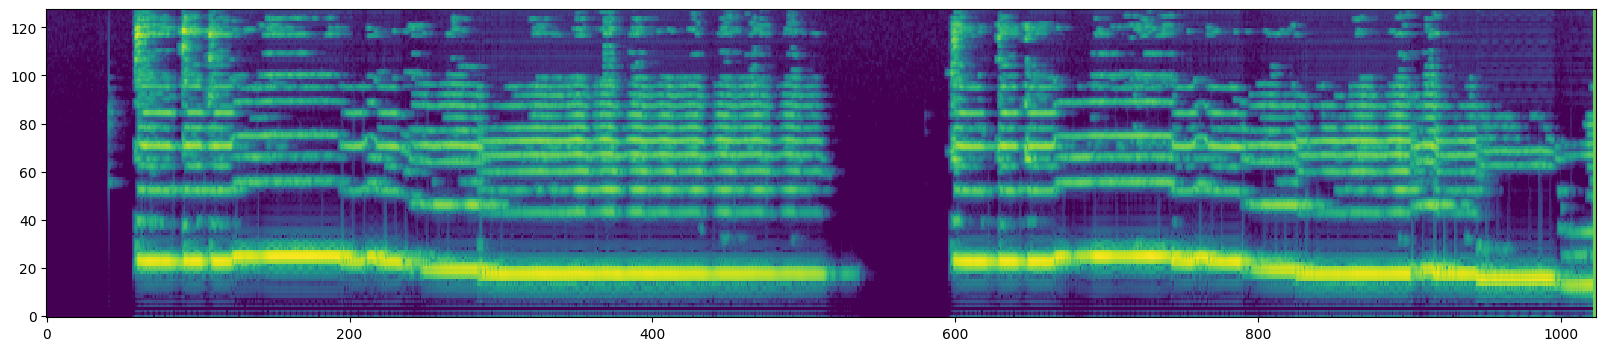

torch.Size([1, 163840]) torch.Size([1, 163840]) torch.Size([1024, 128])


In [198]:
""" Load Dataset """
from IPython.display import display, Audio
from dataset import CustomDataset
from torch.utils.data import DataLoader, Subset
dataset = CustomDataset(path_dir_wb=[ "/mnt/hdd/Dataset/FSD50K_16kHz/FKD50K.eval_audio", 
                                    "/mnt/hdd/Dataset/MUSDB18_HQ_16kHz_mono/test"],
                        path_dir_nb=["/mnt/hdd/Dataset/FSD50K_16kHz_codec/FSD50K.eval_audio",
                                    "/mnt/hdd/Dataset/MUSDB18_MP3_8k/test"], 
                        seg_len=3.6,
                        mode='val',)

total_len = len(dataset)
start_idx = total_len // 2
valid_indices = list(range(start_idx, total_len))
valid_dataset = Subset(dataset, valid_indices)
dataloader = DataLoader(dataset, shuffle=False, batch_size=1)

print(len(valid_dataset))

nb, wb, fbank, name = valid_dataset[3928]
i=0
# for nb, wb, fbank, name in dataloader:
    # i += 1
    # if i == 4000:
        # break
dataset.display_fbank(fbank)

print(nb.shape, wb.shape, fbank.shape)
display(Audio(wb.squeeze(), rate=16000))
display(Audio(nb.squeeze(), rate=16000))

# 5240 minus
# 3011 4011 raining 4012 crowd coughing
# 9014 Guitar
# 9028 Drill
# 9118 dog
# 9168 Flute
# 9216 Harp
# 9219,9222 violin

In [4]:
data = torch.rand(5,1,1024,128)
model = AudioMAEEncoder(visualize=False)
model.load_weights()
out = model(data)
print(out.shape)

*** Weights loaded from pretrained_AS2M.pth ***
torch.Size([5, 64, 6144])


In [5]:
class FeatureReduction(nn.Module):
    def __init__(self):
        super(FeatureReduction, self).__init__()

        self.melpatch_num = 8
        self.patch_len = 768
        self.layers = nn.ModuleList([nn.Linear(self.patch_len,32) for _ in range(self.melpatch_num)])
        # 8 Feature Encoder 768 -> 256 dim
    
    def forward(self, embeddings):
        # embedding: B x Patch x 6144
        outs = []
        for idx, layer in enumerate(self.layers):
            patch_embeddings = embeddings[:, :, idx*self.patch_len:(idx+1)*self.patch_len]
            print(idx, patch_embeddings.shape)
            out = layer(patch_embeddings)
            outs.append(out)
            print(out.shape)
        final_output = torch.cat(outs, dim=-1)

        return final_output
    
model = FeatureReduction()
# print(model(data))

from torchinfo import summary
# print(summary(model, input_data=out))
output = model(out)
print(output.shape)

0 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
1 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
2 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
3 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
4 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
5 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
6 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
7 torch.Size([5, 64, 768])
torch.Size([5, 64, 32])
torch.Size([5, 64, 256])


In [6]:
import torch
import torch.nn as nn
import numpy as np
from torchinfo import summary
import torch.nn.functional as F
import pickle
from einops import rearrange

import pickle
from transformers import HubertModel, AutoProcessor, Wav2Vec2Model, WavLMModel, AutoModel
from AudioMAE.feature_encoder import AudioMAEEncoder

"""
****** Temporal FiLMing ******

n_channels: Number of Conv feature map channels

do not input N x L x C

x: Conv Feature Map (N x C x L)
cond: SSL Condition (N x L/320 x 1024)
        --> N x #FramePatches x F

output:  modulated feature map (N x C x L)

"""
class FiLMLayer(nn.Module):
    def __init__(self, n_channels=8, melpatch_num=3, visualize=False):
        super().__init__()
        self.n_channels = n_channels
        self.film_gen = nn.Linear(256, 2*n_channels)
        self.visualize = visualize

    def forward(self, x, condition):

        ## Start from -> N C L
        ## Condi -> N L C
        subblock_num = condition.size(1)

        if self.visualize: print(condition.shape, "Cond Shape")
        cond = self.film_gen(condition)
        cond = rearrange(cond, 'n l c -> n c l')
        # Extract (ch x subblock_num) gamma and beta 
        gamma = cond[:,:self.n_channels,:].unsqueeze(-1)
        beta = cond[:,self.n_channels:,:].unsqueeze(-1)

        ## Reshape X
        if self.visualize: 
            print("Subblock_num:", subblock_num)
            print(x.shape,"-->", end=' ')

        x = rearrange(x, "n c (b t) -> n c b t", b=subblock_num)

        if self.visualize: 
            print(x.shape)
            print(cond.shape, "SSL Projected Shape")
            print(beta.shape, "BETA Shape")
            print(x.shape, "X Shape")

        # Linear Modulation
        x = gamma * x + beta
        x = rearrange(x, 'n c b t -> n c (b t)')
        if self.visualize:
            print(x.shape, "Concat X Shape")
        return x

"""
# x as a conv feature map shape (B x C x L)
x = torch.rand(3, 4, 16000)
cond = torch.rand(3, #frames, #features)
model = FiLMLayer(n_channels=4, visualize=True)
y = model(x,cond)
print(y.shape)
"""

"""
Input Shape: B x Patch x 6144
Output Shape: B x Patch x 256 
"""
class FeatureReduction(nn.Module):
    def __init__(self):
        super(FeatureReduction, self).__init__()

        self.melpatch_num = 8
        self.patch_len = 768
        self.layers = nn.ModuleList([nn.Linear(self.patch_len,32) for _ in range(self.melpatch_num)])
        # 8 Feature Encoder 768x8 -> 256 dim
    
    def forward(self, embeddings):
        # embedding: B x Patch x 6144
        outs = []
        for idx, layer in enumerate(self.layers):
            patch_embeddings = embeddings[:, :, idx*self.patch_len:(idx+1)*self.patch_len]
            print(idx, patch_embeddings.shape)
            out = layer(patch_embeddings)
            outs.append(out)
            print(out.shape)
        final_output = torch.cat(outs, dim=-1)

        return final_output
    
    

""" Total 1.27 M Parameters """
class SEANet_TFiLM(nn.Module):
    
    def __init__(self, min_dim=8, kmeans_model_path=None, visualize=False, **kwargs):
        # from AudioMAE.models_mae import AudioMAEEncoder

        super().__init__()
        
        self.visualize = visualize

        # Load Kmeans model
        with open(kmeans_model_path, 'rb') as file:
            self.kmeans = pickle.load(file)
                
        self.min_dim = min_dim
        
        ## Load SSL model
        self.ssl_model = AudioMAEEncoder()

        # Freeze SSL Parameters            
        for param in self.ssl_model.parameters():
            param.requires_grad = False

        # Feature Extracted SSL Layers
        self.EmbeddingReduction = FeatureReduction()

        self.melpatch_num = 8 
        self.FiLM_e1 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=16, visualize=self.visualize)
        self.FiLM_e2 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=32, visualize=self.visualize)
        self.FiLM_e3 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=64, visualize=self.visualize)
        self.FiLM_e4 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=128, visualize=self.visualize)

        self.FiLM_b1 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=32, visualize=self.visualize)
        self.FiLM_b2 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=128, visualize=self.visualize)

        self.FiLM_d1 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=64)
        self.FiLM_d2 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=32)
        self.FiLM_d3 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=16)
        self.FiLM_d4 = FiLMLayer(melpatch_num=self.melpatch_num, n_channels=8)

        ## First Conv Layer
        self.conv_in = Conv1d(
            in_channels = 1,
            out_channels = min_dim,
            kernel_size = 7,
            stride = 1
        )

        # Crop factor to match the signal length
        self.downsampling_factor = 2560
        self.encoder = nn.ModuleList([
                                    EncBlock(min_dim*2, 2),
                                    EncBlock(min_dim*4, 2),
                                    EncBlock(min_dim*8, 8),
                                    EncBlock(min_dim*16, 8)                                        
                                    ])
        
        self.conv_bottle1 = Conv1d(
                            in_channels=min_dim*16,
                            out_channels = min_dim*16//4,
                            kernel_size = 7, 
                            stride = 1,
                            )
                        
        self.conv_bottle2 = Conv1d(
                            in_channels=min_dim*16//4,
                            out_channels = min_dim*16,
                            kernel_size = 7,
                            stride = 1,
                            )
        
        self.decoder = nn.ModuleList([
                                    DecBlock(min_dim*8, 8),
                                    DecBlock(min_dim*4, 8),
                                    DecBlock(min_dim*2, 2),
                                    DecBlock(min_dim, 2),
                                    ])
        
        self.conv_out = Conv1d(
            in_channels = min_dim,
            out_channels = 1,
            kernel_size = 7,
            stride = 1,
        )
        
    def quantize_input(self, input_tensor, visualize=False):
        B, T, _ = input_tensor.shape
        kmeans_models = self.kmeans
        num_patches = len(kmeans_models)
        patch_size = 768  # Each patch has 768 dimensions

        quantized_output = []

        for idx in range(num_patches):
            patch_start = patch_size * idx
            patch_end = patch_start + patch_size

            # Extract the patch-specific embeddings
            patch_embeddings = input_tensor[:, :, patch_start:patch_end]  # B x T x 768
            patch_embeddings = patch_embeddings.reshape(-1, patch_size)  # (B*T) x 768
            
            # Use k-means model to quantize the patch embeddings
            kmeans_model = kmeans_models[idx]
            cluster_labels = kmeans_model.predict(patch_embeddings.cpu().numpy())  # (B*T)
            quantized_patch = kmeans_model.cluster_centers_[cluster_labels]  # (B*T) x 768

            # Reshape to original form and append to output
            quantized_patch = torch.tensor(quantized_patch).reshape(B, T, -1)  # B x T x 768
            if visualize: print(f"Patch {idx} quantized shape:", quantized_patch.shape)
            quantized_output.append(quantized_patch)

        # Concatenate all quantized patches along the last dimension
        quantized_output = torch.cat(quantized_output, dim=-1)  # B x T x (8*768)
        if visualize: print(f"Final quantized output shape: {quantized_output.size()}")
        return quantized_output

    def length_adjustment(self, x, cond):
        """
        Adjusts the length of the input signals x and cond to be a multiple of the downsampling factor.
        Returns the adjusted signals and the fragment that was trimmed off.
        """

        # cond : 1024 x 128 -> 1 x 1 x 1024 x 128
        # print(x.shape, cond.shape, "X, Cond")
        if cond.dim() == 2:
            cond = cond.unsqueeze(0).unsqueeze(0)
        elif cond.dim() == 3:
            cond = cond.unsqueeze(1)
        fragment = torch.randn(0).to(x.device)
        downsampling_factor = self.downsampling_factor

        if x.dim() == 3:  # N x 1 x L
            sig_len = x.shape[2]
            if sig_len % downsampling_factor != 0:
                new_len = sig_len // downsampling_factor * downsampling_factor
                fragment = x[:, :, new_len:].clone().to(x.device)
                x = x[:, :, :new_len]

        if x.dim() == 2:
            sig_len = x.shape[1]
            if sig_len % downsampling_factor != 0:
                new_len = sig_len // downsampling_factor * downsampling_factor
                fragment = x[:, new_len:].clone().to(x.device)
                x = x[:, :new_len]

        while len(x.size()) < 3:
            x = x.unsqueeze(-2)

        return x, cond, fragment


    def forward(self, x, cond):
        x, cond, fragment = self.length_adjustment(x, cond) # Length Adjustment
        patch_len = x.shape[2] // (160 * 16)

        # input condition must be [B x 1 x 1024 x 128]
        # print(cond.shape)
        embedding = self.ssl_model(cond, patch_len)
        ################## Kmeans
        embedding = self.quantize_input(embedding).to(x.device)
        embedding = self.EmbeddingReduction(embedding)
        if self.visualize: 
            print("Input Signal Length:", x.shape[2], " Fragment:", fragment.shape)
            print("Patch len:", patch_len)
            print(embedding.shape, "EMBEDDING SHAPE")

        ################## Forward
        # Conv
        skip = [x]
        x = self.conv_in(x)
        skip.append(x)

        if self.visualize: 
            print(embedding.shape, "EMBEDDING: B x L x F")
            print(x.shape, "Conv Feature: B x F x L")

        # Enc
        film_list = [self.FiLM_e1, self.FiLM_e2, self.FiLM_e3, self.FiLM_e4]
        for i, encoder in enumerate(self.encoder):
            x = encoder(x)
            x = film_list[i](x, embedding)
            # print("\t x.shape", x.shape)
            skip.append(x)

        # Bottleneck
        x = self.conv_bottle1(x) 
        x = self.FiLM_b1(x, embedding)
        x = self.conv_bottle2(x) 
        x = self.FiLM_b2(x, embedding)

        # Dec
        skip = skip[::-1]
        film_list_d = [self.FiLM_d1, self.FiLM_d2, self.FiLM_d3, self.FiLM_d4]
        for l in range(len(self.decoder)):
            x = x + skip[l]
            x = self.decoder[l](x)
            x = film_list_d[l](x, embedding)
            # print("\t x.shape", x.shape)
        x = x + skip[4]
        x = self.conv_out(x)
        x = x + skip[5]

        # Length Adjustment: Append the fragment back
        if len(fragment.size()) == 2:
            fragment = fragment.unsqueeze(-2)

        x = torch.cat((x, fragment), dim=-1)

        return x

class EncBlock(nn.Module):
    def __init__(self, out_channels, stride):
        super().__init__()
        

        self.res_units = nn.ModuleList([
                                    ResUnit(out_channels//2, 1),
                                    ResUnit(out_channels//2, 3),
                                    ResUnit(out_channels//2, 9)                                        
                                    ])
        
        self.conv = nn.Sequential(
                    nn.ELU(),
                    Pad((2 * stride - 1, 0)),
                    nn.Conv1d(in_channels = out_channels//2,
                                       out_channels = out_channels,
                                       kernel_size = 2 * stride,
                                       stride = stride, padding = 0),
                    )  
        
        
    def forward(self, x):
        
        for res_unit in self.res_units:
            x = res_unit(x)
        x = self.conv(x)

        return x
        
    
class DecBlock(nn.Module):
    def __init__(self, out_channels, stride):
        super().__init__()

        ## Channel Reduction & Upsampling
        self.conv = ConvTransposed1d(
                                 in_channels = out_channels*2, 
                                 out_channels = out_channels, 
                                 kernel_size = 2*stride, stride= stride,
                                 dilation = 1,
                                 )
        
        
        self.res_units = nn.ModuleList([
                                    ResUnit(out_channels, 1),
                                    ResUnit(out_channels, 3),
                                    ResUnit(out_channels, 9)                                       
                                    ])
               
        self.stride = stride
        

    def forward(self, x):
        x = self.conv(x)
        for res_unit in self.res_units:
            x = res_unit(x)
        return x
    
    
class ResUnit(nn.Module):
    def __init__(self, channels, dilation = 1):
        super().__init__()
        

        self.conv_in = Conv1d(
                                 in_channels = channels, 
                                 out_channels = channels, 
                                 kernel_size = 3, stride= 1,
                                 dilation = dilation,
                                 )
        
        self.conv_out = Conv1d(
                                in_channels = channels, 
                                 out_channels = channels, 
                                 kernel_size = 1, stride= 1,
                                 )
        
        self.conv_shortcuts = Conv1d(
                                in_channels = channels, 
                                 out_channels = channels, 
                                 kernel_size = 1, stride= 1,
                                 )
        
    
        
    def forward(self, x):
        y = self.conv_in(x)
        y = self.conv_out(y)
        x = self.conv_shortcuts(x)
        return x + y
        
    
class Conv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, dilation = 1, groups = 1):
        super().__init__()
        
        self.conv = nn.Conv1d(
            in_channels = in_channels, 
            out_channels = out_channels,
            kernel_size= kernel_size, 
            stride= stride, 
            dilation = dilation,
            groups = groups
        )
        self.conv = nn.utils.weight_norm(self.conv)
        
        self.pad = Pad(((kernel_size-1)*dilation, 0)) 
        self.activation = nn.ELU()
            

    def forward(self, x):

        x = self.pad(x)
        x = self.conv(x)
        x = self.activation(x)
        
        return x

class ConvTransposed1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 1, stride = 1, dilation = 1):
        super().__init__()
        self.conv = nn.ConvTranspose1d(
            in_channels = in_channels,
            out_channels = out_channels,
            kernel_size = kernel_size,
            stride =stride,
            dilation = dilation
        )
        self.conv = nn.utils.weight_norm(self.conv)
        
        self.activation = nn.ELU()
        self.pad = dilation * (kernel_size - 1) - dilation * (stride - 1)
        
    def forward(self, x):
        x = self.conv(x)
        x = x[..., :-self.pad]
        x = self.activation(x)
        return x
    
class Pad(nn.Module):
    def __init__(self, pad):
        super().__init__()
        self.pad = pad
    
    def forward(self, x):
        return F.pad(x, pad=self.pad)   

In [13]:
model = SEANet_TFiLM(kmeans_model_path="/home/woongjib/Projects/BESSL/kmeans/K64_MAE.pkl", visualize=True)
data = torch.rand(1,32000)
mel = torch.rand(1024,128)
# print(model(data,mel).shape)
# summary(model, input_data = data,mel))
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params / 1000000, "M")

1.022858 M
